In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
#Import Libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator #On-the-fly loading and augmentation
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [ ]:
#Move images into colab env for speed
!cp -r '/content/drive/MyDrive/MLProjects/pneumonia-detection/data/pneumonia_scaled' /content/data/

In [ ]:
#Load dataset
data_dir = '/content/data/'

train_datagen = ImageDataGenerator(
    #Normalizes pixel values:
    rescale=1./255,
    validation_split=0.2,
    #Help model to generalize:
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True

)

train_data = train_datagen.flow_from_directory(
    data_dir,
    #Resizes images to 224 x 224:
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

Found 13145 images belonging to 2 classes.
Found 13145 images belonging to 2 classes.


In [ ]:
#Handle Imbalance by calculating the class weights
counter = Counter(train_data.classes)
labels = [label for label in train_data.classes]
weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = {i: w for i, w in enumerate(weights)}

print('Class weights: ', class_weights)

Class weights:  {0: np.float64(0.5477083333333334), 1: np.float64(5.740174672489083)}


In [20]:
#Build transfer learning model with VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Freeze base layers
for layer in base_model.layers:
  layer.trainable=False

#Add custom classifier head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

#Unfreeze the last 4 layers of VGG16
for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
early_stop = EarlyStopping(
    monitor='val_loss',       # Watch validation loss
    patience=2,               # Stop after 2 epochs if no improvement
    restore_best_weights=True  # Revert to the best weights seen during training
)

#Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 691s 2s/step - accuracy: 0.5948 - loss: 0.7810 - val_accuracy: 0.7223 - val_loss: 0.5918
Epoch 2/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 677s 2s/step - accuracy: 0.6593 - loss: 0.6369 - val_accuracy: 0.7581 - val_loss: 0.5654
Epoch 3/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 685s 2s/step - accuracy: 0.7214 - loss: 0.5870 - val_accuracy: 0.7651 - val_loss: 0.5458
Epoch 4/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 726s 2s/step - accuracy: 0.7408 - loss: 0.5703 - val_accuracy: 0.6790 - val_loss: 0.6525
Epoch 5/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 682s 2s/step - accuracy: 0.7269 - loss: 0.5592 - val_accuracy: 0.7582 - val_loss: 0.5465


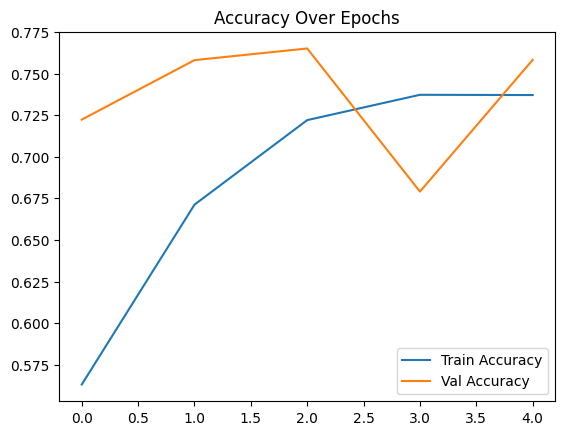

In [23]:
#Plot training curves
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

In [24]:
model.save('/content/drive/MyDrive/chest_xray_scaled_model_final.h5')

## **Summary: Scaling the Pneumonia Detection Prototype**


This notebook demonstrates that the pneumonia detection model can scale to large volumes of chest X-ray data and make trade-offs that support real-world deployment.

### Dataset and Loading
- NIH Chest X-ray dataset (16,431 images used: 15,000 normal, 1,431 pneumonia)
- Loaded using ImageDataGenerator with real-time augmentation and disk streaming
- 80/20 training-validation split
- Batch size: 32, image size: 224×224

### Class Imbalance Handling
- Class ratio around 10:1 (normal:pneumonia)
- Used class_weight with scikit-learn to address imbalance without oversampling

### Model Architecture and Tools
- Transfer learning with VGG16 (pretrained on ImageNet)
- All base layers frozen; last 4 layers unfrozen for fine-tuning
- Custom head is GlobalAveragePooling > Dropout(0.5) > Dense(1, sigmoid)
- Optimizer: Adam with learning rate 1e-5
- Loss: Binary crossentropy

### Training Outcome
- Trained for 5 epochs (with early stopping)
- Best validation accuracy: 76.5%
- Training accuracy: 72.7%
- Validation loss: 0.5458


### Key Trade-Offs
| Decision Area | Choice Made | Reason |
|---------------|-------------|--------|
| Dataset size vs. speed | Used 16k images | Simulates large-scale real-world dataset |
| Model size vs. flexibility | Fine-tuned top 4 layers only | Reduces training time; balances generalization |
| Imbalance method | Used class_weight | Simpler and explainable vs. focal loss |
| Data pipeline | Used ImageDataGenerator | Fast, memory-efficient, supports augmentation |
